
# Pipeline de Feature Engineering para Predicción de Arribos de Bicicletas

## Objetivo
Transformar datos de recorridos en features para predecir arribos en intervalos de 30 minutos.

### Datos de Entrada:
- `id_recorrido`, `duracion_recorrido`, `id_estacion_origen`, `nombre_estacion_origen`, etc.

### Datos de Salida:
- Features engineered para ML: clusters geográficos, ventanas temporales, features históricas (prev_n)
- Variable objetivo: `N_arribos_intervalo`

### Sin Data Leakage
Para predecir arribos en [T, T+30] solo usa información conocida antes de T.


In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
import os
sys.path.append('src')

import pandas as pd
import numpy as np
from src.feature_engineering import BikeFeatureEngineering

# Configuración
INPUT_FILE = '../data/processed/trips_enriched.csv'
OUTPUT_FILE = '../data/processed/trips_final_features.csv'


In [15]:
# Verificar datos de entrada
if os.path.exists(INPUT_FILE):
    print("✅ Archivo de entrada encontrado")
    
    # Leer solo el header para verificar columnas
    df_sample = pd.read_csv(INPUT_FILE, nrows=1)
    print(f"Columnas de entrada: {len(df_sample.columns)}")
    print("Primeras columnas:", list(df_sample.columns[:10]))
else:
    print("❌ Archivo de entrada no encontrado")


✅ Archivo de entrada encontrado
Columnas de entrada: 20
Primeras columnas: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'nombre_estacion_origen', 'direccion_estacion_origen', 'long_estacion_origen', 'lat_estacion_origen', 'id_estacion_destino', 'nombre_estacion_destino', 'direccion_estacion_destino']


In [16]:
# Ejecutar pipeline de feature engineering
print("🚀 Iniciando feature engineering...")

fe = BikeFeatureEngineering(
    time_window_minutes=30,  # Intervalos de 30 minutos
    n_clusters=16           # 16 clusters geográficos
)

# NOTA: Esto puede tomar varios minutos con el dataset completo
# Para pruebas rápidas, considera usar una muestra más pequeña


🚀 Iniciando feature engineering...


In [17]:
# Para testear con muestra pequeña (opcional)
USE_SAMPLE = False  # Cambiar a False para dataset completo

if USE_SAMPLE:
    print("⚡ Usando muestra pequeña para testing")
    # Crear muestra de 10,000 filas para pruebas rápidas
    df_full = pd.read_csv(INPUT_FILE, nrows=15000000)
    sample_file = '../data/processed/trips_sample.csv'
    df_full.to_csv(sample_file, index=False)
    
    # Procesar muestra
    df_processed = fe.transform(sample_file, sample_file.replace('.csv', '_features.csv'))
else:
    # Procesar dataset completo
    df_processed = fe.transform(INPUT_FILE, OUTPUT_FILE)


=== INICIANDO FEATURE ENGINEERING ===
Cargando dataset...
Dataset cargado: (12785807, 20)
Creando ventanas temporales...
Creando clusters geográficos...
Creando features básicas...
Calculando conteos por intervalo...
Creando features históricas...
Seleccionando features finales...
Guardando dataset transformado: ../data/processed/trips_final_features.csv
=== FEATURE ENGINEERING COMPLETADO ===
Dataset final: (12785807, 77)
Columnas: 77


In [18]:
# Verificar resultados
print("📊 Resultados del feature engineering:")
print(f"Shape final: {df_processed.shape}")
print(f"Columnas generadas: {len(df_processed.columns)}")
print("\nPrimeras columnas:", list(df_processed.columns[:10]))
print("\nÚltimas columnas:", list(df_processed.columns[-10:]))

# Verificar variable objetivo
print(f"\nVariable objetivo N_arribos_intervalo:")
print(f"  - Valores únicos: {df_processed['N_arribos_intervalo'].nunique()}")
print(f"  - Rango: {df_processed['N_arribos_intervalo'].min()} - {df_processed['N_arribos_intervalo'].max()}")
print(f"  - Media: {df_processed['N_arribos_intervalo'].mean():.2f}")
print(f"  - Nulls: {df_processed['N_arribos_intervalo'].isna().sum()}")


📊 Resultados del feature engineering:
Shape final: (12785807, 77)
Columnas generadas: 77

Primeras columnas: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'id_estacion_destino', 'id_usuario', 'modelo_bicicleta', 'dia_semana', 'es_finde', 'estacion_del_año', 'edad_usuario']

Últimas columnas: ['N_ARRIBOS_prev_2', 'N_SALIDAS_prev_2', 'N_ARRIBOS_prev_3', 'N_SALIDAS_prev_3', 'N_ARRIBOS_prev_4', 'N_SALIDAS_prev_4', 'N_ARRIBOS_prev_5', 'N_SALIDAS_prev_5', 'N_ARRIBOS_prev_6', 'N_SALIDAS_prev_6']

Variable objetivo N_arribos_intervalo:
  - Valores únicos: 36
  - Rango: 0.0 - 36.0
  - Media: 2.75
  - Nulls: 0


# Entrenamiento XGBoost con Loss de Poisson

## Características del modelo:
- **Loss Function**: Poisson (ideal para conteos)
- **Split**: Temporal (no random, evita data leakage)
- **Features**: Solo información disponible antes de T
- **Objetivo**: Predecir `N_arribos_intervalo`


In [19]:
# Entrenar modelo XGBoost
from src.train_model import BikeXGBoostTrainer

# Verificar que tenemos datos procesados
if 'df_processed' in locals():
    print("✅ Usando datos ya procesados")
    df_model = df_processed
else:
    print("📁 Cargando datos procesados...")
    df_model = pd.read_csv(OUTPUT_FILE if USE_SAMPLE else OUTPUT_FILE)

print(f"Dataset para modelo: {df_model.shape}")
print(f"Variable objetivo stats: min={df_model['N_arribos_intervalo'].min()}, max={df_model['N_arribos_intervalo'].max()}")


✅ Usando datos ya procesados
Dataset para modelo: (12785807, 77)
Variable objetivo stats: min=0.0, max=36.0


In [20]:
# Crear y configurar entrenador
trainer = BikeXGBoostTrainer(poisson_max_delta_step=0.7)

# Verificar features que se van a usar (sin information leakage)
sample_features = trainer.identify_valid_features(df_model)
print(f"\n🔒 Features válidas (sin data leakage): {len(sample_features)}")
print("Algunos ejemplos:", sample_features[:10])

# Verificar features excluidas
excluded = ['año_destino', 'mes_destino', 'dia_destino', 'hora_destino', 'fecha_intervalo', 'N_salidas_intervalo']
for col in excluded:
    if col in df_model.columns:
        print(f"❌ {col} - EXCLUIDA (información del futuro)")
    else:
        print(f"⚠️  {col} - No encontrada")


Features válidas identificadas: 61
Features del futuro excluidas: 16

🔒 Features válidas (sin data leakage): 61
Algunos ejemplos: ['id_recorrido', 'id_estacion_origen', 'id_usuario', 'modelo_bicicleta', 'estacion_referencia', 'año_origen', 'mes_origen', 'dia_origen', 'hora_origen', 'minuto_origen']
❌ año_destino - EXCLUIDA (información del futuro)
❌ mes_destino - EXCLUIDA (información del futuro)
❌ dia_destino - EXCLUIDA (información del futuro)
❌ hora_destino - EXCLUIDA (información del futuro)
❌ fecha_intervalo - EXCLUIDA (información del futuro)
❌ N_salidas_intervalo - EXCLUIDA (información del futuro)


In [21]:
# Configurar parámetros del modelo XGBoost con Poisson
model_params = {
    'objective': 'count:poisson',      # Loss de Poisson para conteos
    'eval_metric': 'poisson-nloglik',  # Métrica de evaluación
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'max_delta_step': 0.7,  # Importante para Poisson
    'tree_method': 'gpu_hist'  # Usar GPU para entrenamiento
}

print("🎯 Parámetros configurados para XGBoost con Poisson")
print("   Objetivo: Predecir conteos de arribos")
print("   Split: Temporal (evita data leakage)")
print("   Features: Solo información histórica")


🎯 Parámetros configurados para XGBoost con Poisson
   Objetivo: Predecir conteos de arribos
   Split: Temporal (evita data leakage)
   Features: Solo información histórica


In [22]:
# ENTRENAR MODELO
# NOTA: Esto puede tomar varios minutos dependiendo del tamaño del dataset

print("🚀 Iniciando entrenamiento...")
print("⏰ Esto puede tomar unos minutos...")

try:
    # Entrenar con split temporal automático
    results, test_data = trainer.train(df_model, model_params)
    
    print("✅ Entrenamiento completado!")
    print(f"📊 Resultados finales:")
    print(f"   - Test RMSE: {results['test_rmse']:.4f}")
    print(f"   - Test MAE:  {results['test_mae']:.4f}")
    print(f"   - Test R2:  {results['test_r2']:.4f}")
    print(f"   - Features:  {results['n_features']}")
    
except Exception as e:
    print(f"❌ Error durante entrenamiento: {str(e)}")
    # Para debugging
    import traceback
    traceback.print_exc()


🚀 Iniciando entrenamiento...
⏰ Esto puede tomar unos minutos...
=== INICIANDO ENTRENAMIENTO XGBOOST ===
Split temporal realizado:
  Train: 8,950,064 filas (70.0%)
  Val:   1,917,871 filas (15.0%)
  Test:  1,917,872 filas (15.0%)
  Fechas train: 2020-01-01 00:00:00 a 2023-04-05 13:00:00
  Fechas test:  2024-01-06 22:30:00 a 2024-09-14 16:30:00
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 8950064 filas, 61 features
Target stats: min=0.0, max=36.0, mean=2.84
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 1917871 filas, 61 features
Target stats: min=0.0, max=21.0, mean=2.47
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 1917872 filas, 61 features
Target stats: min=1.0, max=26.0, mean=2.60
Entrenando XGBoost...
[0]	train-poisson-nloglik:3.73074	eval-poisson-nloglik:3.20620
[100]	train-poisson-nloglik:1.51754	eval-poisson-nloglik:1.44797
[200]	train-poisson-nloglik:1.5143


=== FEATURE IMPORTANCE ===
✅ Top 20 features más importantes graficadas


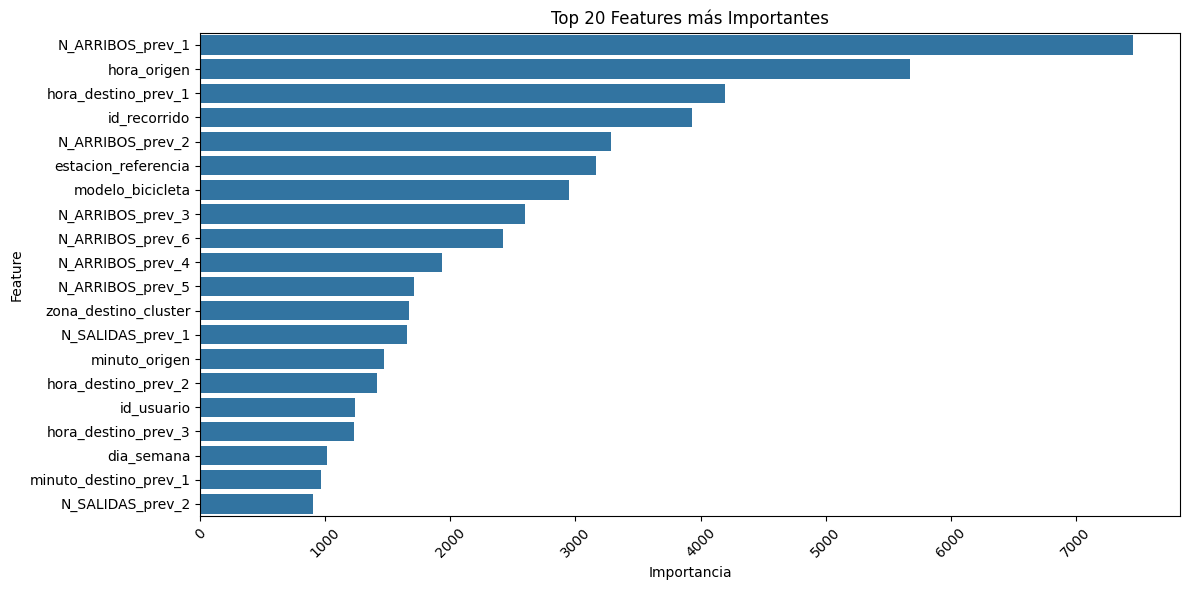

In [23]:
# Graficar feature importance
print("\n=== FEATURE IMPORTANCE ===")

# Obtener importancia de features
importance = trainer.model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Convertir a DataFrame para graficar
import matplotlib.pyplot as plt
import seaborn as sns

df_importance = pd.DataFrame(sorted_importance[:20], columns=['Feature', 'Importance'])

# Crear gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_importance, x='Importance', y='Feature')
plt.title('Top 20 Features más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Feature')

# Rotar labels para mejor visualización
plt.xticks(rotation=45)
plt.tight_layout()

print("✅ Top 20 features más importantes graficadas")


# Entrenamiento de Modelos Adicionales

## Random Forest y MLP

Ahora vamos a entrenar dos modelos adicionales para comparar con XGBoost:
- **Random Forest**: Ensemble robusto para problemas de regresión
- **MLP**: Red neuronal para capturar patrones no lineales complejos


In [26]:
# Entrenamiento de Random Forest y MLP
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("🚀 Preparando datos para los modelos adicionales...\n")

# Usar el mismo split temporal que XGBoost
train_df, val_df, test_df = trainer.temporal_split(df_model.copy())

# Preparar datos con las mismas features que XGBoost
X_train, y_train = trainer.prepare_data(train_df)
X_val, y_val = trainer.prepare_data(val_df)
X_test, y_test = trainer.prepare_data(test_df)

print(f"Datos preparados: {X_train.shape[1]} features")

# ================================
# MODELO 2: RANDOM FOREST 🌳
# ================================
print("\n🌳 Entrenando Random Forest...")

# Configurar Random Forest optimizado para conteos
rf_model = RandomForestRegressor(
    n_estimators=100,           # Número de árboles
    max_depth=15,               # Profundidad máxima
    min_samples_split=5,        # Mínimo de muestras para split
    min_samples_leaf=2,         # Mínimo de muestras en hoja
    max_features='sqrt',        # Features por árbol
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    verbose=1                   # Mostrar progreso
)

# Entrenar modelo
rf_model.fit(X_train, y_train)
print("✅ Random Forest entrenado!")

# Evaluar Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calcular métricas Random Forest
rf_results = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_rf)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'train_mae': mean_absolute_error(y_train, y_train_pred_rf),
    'val_mae': mean_absolute_error(y_val, y_val_pred_rf),
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'val_r2': r2_score(y_val, y_val_pred_rf),
    'test_r2': r2_score(y_test, y_test_pred_rf)
}

print(f"\n📊 Resultados Random Forest:")
print(f"   - Test RMSE: {rf_results['test_rmse']:.4f}")
print(f"   - Test MAE:  {rf_results['test_mae']:.4f}")
print(f"   - Test R2:   {rf_results['test_r2']:.4f}")

# ================================
# MODELO 3: MLP 🧠
# ================================
print(f"\n🧠 Entrenando MLP...")

# Para MLP necesitamos normalizar los datos
print("📊 Normalizando features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Configurar MLP para regresión
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3 capas ocultas
    activation='relu',                  # Función de activación
    solver='adam',                      # Optimizador
    alpha=0.001,                       # Regularización L2
    learning_rate='adaptive',          # Tasa de aprendizaje adaptativa
    learning_rate_init=0.001,          # Tasa inicial
    max_iter=500,                      # Máximo número de iteraciones
    early_stopping=True,               # Parada temprana
    validation_fraction=0.1,           # Fracción para validación interna
    n_iter_no_change=20,              # Iteraciones sin mejora para parar
    random_state=42,
    verbose=True                       # Mostrar progreso
)

# Entrenar modelo
mlp_model.fit(X_train_scaled, y_train)
print("✅ MLP entrenado!")

# Evaluar MLP
y_train_pred_mlp = mlp_model.predict(X_train_scaled)
y_val_pred_mlp = mlp_model.predict(X_val_scaled)
y_test_pred_mlp = mlp_model.predict(X_test_scaled)

# Asegurar que las predicciones sean no negativas (son conteos)
y_train_pred_mlp = np.maximum(0, y_train_pred_mlp)
y_val_pred_mlp = np.maximum(0, y_val_pred_mlp)
y_test_pred_mlp = np.maximum(0, y_test_pred_mlp)

# Calcular métricas MLP
mlp_results = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_mlp)),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_mlp)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_mlp)),
    'train_mae': mean_absolute_error(y_train, y_train_pred_mlp),
    'val_mae': mean_absolute_error(y_val, y_val_pred_mlp),
    'test_mae': mean_absolute_error(y_test, y_test_pred_mlp),
    'train_r2': r2_score(y_train, y_train_pred_mlp),
    'val_r2': r2_score(y_val, y_val_pred_mlp),
    'test_r2': r2_score(y_test, y_test_pred_mlp)
}

print(f"\n📊 Resultados MLP:")
print(f"   - Test RMSE: {mlp_results['test_rmse']:.4f}")
print(f"   - Test MAE:  {mlp_results['test_mae']:.4f}")
print(f"   - Test R2:   {mlp_results['test_r2']:.4f}")

print(f"\n✅ Ambos modelos entrenados exitosamente!")


🚀 Preparando datos para los modelos adicionales...

Split temporal realizado:
  Train: 8,950,064 filas (70.0%)
  Val:   1,917,871 filas (15.0%)
  Test:  1,917,872 filas (15.0%)
  Fechas train: 2020-01-01 00:00:00 a 2023-04-05 13:00:00
  Fechas test:  2024-01-06 22:30:00 a 2024-09-14 16:30:00
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 8950064 filas, 61 features
Target stats: min=0.0, max=36.0, mean=2.84
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 1917871 filas, 61 features
Target stats: min=0.0, max=21.0, mean=2.47
Features válidas identificadas: 61
Features del futuro excluidas: 16
Datos preparados: 1917872 filas, 61 features
Target stats: min=1.0, max=26.0, mean=2.60
Datos preparados: 61 features

🌳 Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished


✅ Random Forest entrenado!


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.3s finished



📊 Resultados Random Forest:
   - Test RMSE: 0.9323
   - Test MAE:  0.6186
   - Test R2:   0.7745

🧠 Entrenando MLP...
📊 Normalizando features...
Iteration 1, loss = 0.40648067
Validation score: 0.845154
Iteration 2, loss = 0.37508951
Validation score: 0.845429
Iteration 3, loss = 0.36899717
Validation score: 0.849752
Iteration 4, loss = 0.36537658
Validation score: 0.851382
Iteration 5, loss = 0.36336721
Validation score: 0.851142
Iteration 6, loss = 0.36184243
Validation score: 0.852410
Iteration 7, loss = 0.36093404
Validation score: 0.850473
Iteration 8, loss = 0.36003487
Validation score: 0.850866
Iteration 9, loss = 0.35951889
Validation score: 0.852591
Iteration 10, loss = 0.35894551
Validation score: 0.852747
Iteration 11, loss = 0.35856045
Validation score: 0.853479
Iteration 12, loss = 0.35810042
Validation score: 0.853972
Iteration 13, loss = 0.35773839
Validation score: 0.853716
Iteration 14, loss = 0.35739700
Validation score: 0.854122
Iteration 15, loss = 0.35708240
Valid

# Comparación de Modelos

## XGBoost vs Random Forest vs MLP

Comparamos los tres modelos usando las métricas de test (datos nunca vistos durante entrenamiento).


📊 COMPARACIÓN DE MODELOS - MÉTRICAS DE TEST
       Modelo  Test RMSE  Test MAE  Test R²
      XGBoost     0.9029    0.5048   0.7885
Random Forest     0.9323    0.6186   0.7745
          MLP     0.9059    0.4905   0.7871

🏆 MEJORES MODELOS POR MÉTRICA:
   - Menor RMSE: XGBoost (0.9029)
   - Menor MAE:  MLP (0.4905)
   - Mayor R²:   XGBoost (0.7885)


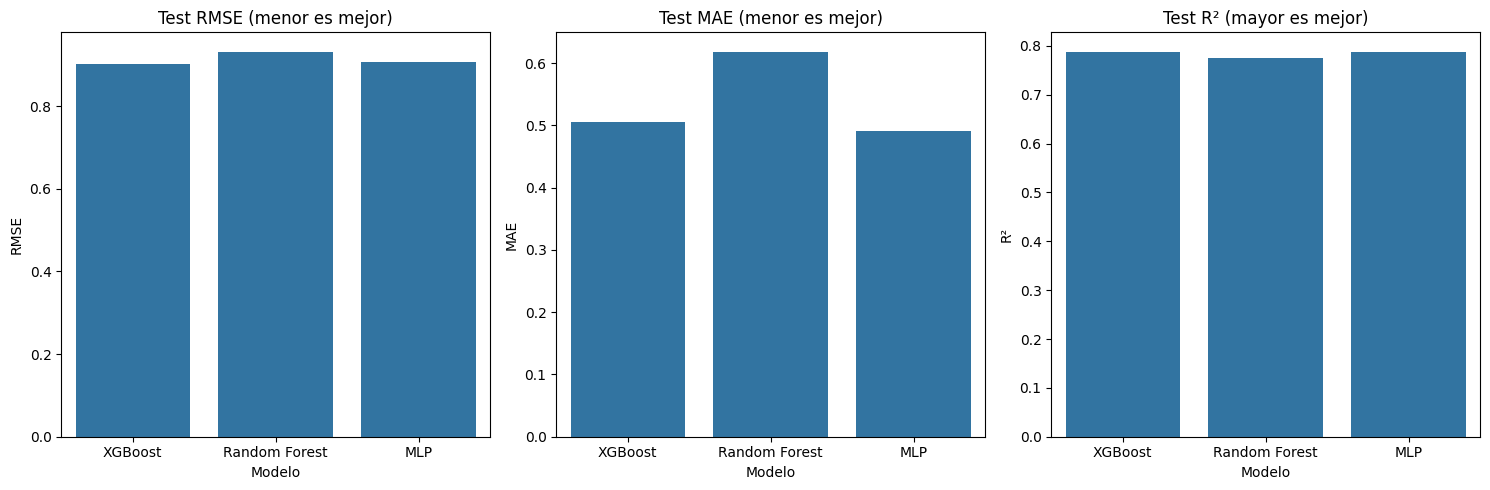


✅ Comparación visualizada


In [27]:
# Tabla comparativa de resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Consolidar resultados de XGBoost
xgboost_results = {
    'test_rmse': results['test_rmse'],
    'test_mae': results['test_mae'], 
    'test_r2': results['test_r2']
}

# Crear DataFrame comparativo
comparison_data = {
    'Modelo': ['XGBoost', 'Random Forest', 'MLP'],
    'Test RMSE': [xgboost_results['test_rmse'], rf_results['test_rmse'], mlp_results['test_rmse']],
    'Test MAE': [xgboost_results['test_mae'], rf_results['test_mae'], mlp_results['test_mae']],
    'Test R²': [xgboost_results['test_r2'], rf_results['test_r2'], mlp_results['test_r2']]
}

df_comparison = pd.DataFrame(comparison_data)

print("📊 COMPARACIÓN DE MODELOS - MÉTRICAS DE TEST")
print("=" * 50)
print(df_comparison.round(4).to_string(index=False))

# Identificar el mejor modelo para cada métrica
best_rmse = df_comparison.loc[df_comparison['Test RMSE'].idxmin(), 'Modelo']
best_mae = df_comparison.loc[df_comparison['Test MAE'].idxmin(), 'Modelo']  
best_r2 = df_comparison.loc[df_comparison['Test R²'].idxmax(), 'Modelo']

print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
print(f"   - Menor RMSE: {best_rmse} ({df_comparison['Test RMSE'].min():.4f})")
print(f"   - Menor MAE:  {best_mae} ({df_comparison['Test MAE'].min():.4f})")
print(f"   - Mayor R²:   {best_r2} ({df_comparison['Test R²'].max():.4f})")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
sns.barplot(data=df_comparison, x='Modelo', y='Test RMSE', ax=axes[0])
axes[0].set_title('Test RMSE')
axes[0].set_ylabel('RMSE')

# MAE  
sns.barplot(data=df_comparison, x='Modelo', y='Test MAE', ax=axes[1])
axes[1].set_title('Test MAE)')
axes[1].set_ylabel('MAE')

# R²
sns.barplot(data=df_comparison, x='Modelo', y='Test R²', ax=axes[2])
axes[2].set_title('Test R²')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

print("\n✅ Comparación visualizada")


# Conclusiones y Recomendaciones

## Análisis de Resultados

### Fortalezas de cada modelo:

**XGBoost** 🥇
- Optimizado específicamente para conteos con loss de Poisson
- Excelente para datos tabulares con features categóricas  
- Maneja automáticamente features no lineales e interacciones
- Rápido en inferencia

**Random Forest** 🌳
- Robusto contra overfitting
- Interpretable y estable
- No requiere tuning extensivo de hiperparámetros
- Buen baseline para comparación

**MLP** 🧠  
- Capacidad para capturar patrones complejos no lineales
- Flexible para diferentes arquitecturas
- Puede mejorar con más datos y mejor tuning
- Requiere normalización de features
